In [1]:
from astroquery.gaia import Gaia
from astropy import units as u
from astropy import wcs
import astropy.coordinates as coord
from astropy.constants import h, c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [66]:
# Constants
fd_unit = u.J/u.m**2/u.s/u.nm
d_filters = {'Band':['G','BP','RP'],'Wavelength':[639.07*u.nm,518.26*u.nm,782.51*u.nm],'Bandpass':[454.82*u.nm,265.9*u.nm,292.75*u.nm],'clam':[1.346e-21*fd_unit,3.009e-21*fd_unit,1.638e-21*fd_unit]} 
filters = pd.DataFrame(data=d_filters)
qe = pd.read_csv('QE.csv',delimiter=',',index_col=0)

ccd_width_px = 4656
ccd_height_px = 3520
ccd_px_side_length_micron = 3.8 * u.micron
ccd_width_micron = ccd_width_px * ccd_px_side_length_micron
ccd_height_micron = ccd_height_px * ccd_px_side_length_micron
plate_scale_arcsec_micron = 0.11 * u.arcsec/u.micron
px_dec = plate_scale_arcsec_micron * ccd_px_side_length_micron
px_ra = plate_scale_arcsec_micron * ccd_px_side_length_micron
ccd_width_range_arcsec = ccd_width_micron * plate_scale_arcsec_micron
ccd_height_range_arcsec = ccd_height_micron * plate_scale_arcsec_micron
ccd_width_range_deg = ccd_width_range_arcsec.to(u.deg)
ccd_height_range_deg = ccd_height_range_arcsec.to(u.deg)
mast_collecting_area_m2 = 0.09 * np.pi * 0.5 * u.m**2
gaia_collecting_area_m2 = 0.7 * u.m**2
ccd_full_well = 20000 * u.electron
gaia_mast_attenuation = 0.5

In [4]:
ra_widget = widgets.BoundedFloatText(
    value=279.3643447,
    min=0,
    max=360,
    step=0.001,
    description='RA:'
)
dec_widget = widgets.BoundedFloatText(
    value=38.79739118,
    min=-90,
    max=90,
    step=0.001,
    description='DEC:'
)
max_mag_widget = widgets.FloatText(
    value=18,
    step=0.01,
    description='Max Mag:'
)
display(ra_widget)
display(dec_widget)
display(max_mag_widget)


BoundedFloatText(value=279.3643447, description='RA:', max=360.0, step=0.001)

BoundedFloatText(value=38.79739118, description='DEC:', max=90.0, min=-90.0, step=0.001)

FloatText(value=18.0, description='Max Mag:', step=0.01)

In [11]:
def get_entries(max_mag, ra, dec, ccd_width_range_deg, ccd_height_range_deg):
    query = '''SELECT TOP 100 SOURCE_ID, RA, DEC, PHOT_G_MEAN_MAG, HAS_XP_SAMPLED,
PHOT_G_MEAN_FLUX AS PHOT_G_MEAN_FLUX_GAIA, PHOT_G_MEAN_FLUX_ERROR AS PHOT_G_MEAN_FLUX_ERROR_GAIA,
PHOT_BP_MEAN_FLUX AS PHOT_BP_MEAN_FLUX_GAIA, PHOT_BP_MEAN_FLUX_ERROR AS PHOT_BP_MEAN_FLUX_ERROR_GAIA,
PHOT_RP_MEAN_FLUX AS PHOT_RP_MEAN_FLUX_GAIA, PHOT_RP_MEAN_FLUX_ERROR AS PHOT_RP_MEAN_FLUX_ERROR_GAIA
FROM gaiadr3.gaia_source
WHERE (ra BETWEEN {ra_min} AND {ra_max})
AND (dec BETWEEN {dec_min} AND {dec_max})
AND phot_g_mean_mag < {max_mag}
'''.format(
        max_mag=max_mag,
        ra_min=ra-(ccd_width_range_deg.value/2), ra_max=ra+(ccd_width_range_deg.value/2),
        dec_min=dec-(ccd_height_range_deg.value/2), dec_max=dec+(ccd_height_range_deg.value/2)
    )
    job = Gaia.launch_job(query)
    r = job.get_results()
    return r

In [70]:
def convert_to_flux_density(table):
    # gets flux mean, flux error in electrons/sec (as given in GAIA_SOURCE) and name of band {'G','BP,'RP'}
    # returns flux density + uncertainty in watt/m^2/nm
    for filter in d_filters['Band']:
        table['flux_' + filter + '_density_gaia'] = filters[filters['Band'] == filter]['clam'].iloc[0] * table['phot_' + str.lower(filter) + '_mean_flux_gaia'].value # convert to incoming flux density
        table['flux_' + filter + '_density_error_gaia'] =  filters[filters['Band'] == filter]['clam'].iloc[0] * table['phot_' + str.lower(filter) + '_mean_flux_error_gaia'].value

def get_flux_from_spectrum(source_id,lmin,lmax):
    datalink = Gaia.load_data(ids=source_id, data_release = 'Gaia DR3', retrieval_type='XP_SAMPLED', data_structure = 'INDIVIDUAL', verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()
    t = datalink[dl_key][0]
    t = t.to_table()
    y1arr = qe['QE'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)]
    y2arr = np.ma.getdata(t['flux'].value)[int((lmin.value-336)/2):int((lmax.value-336)/2)]
    xarr = qe['Wavelength'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)]
    fmast = np.trapz(y1arr*y2arr*xarr*1e-9/h.value/c.value,xarr)*gaia_mast_attenuation*mast_collecting_area_m2*u.electron/u.m**2/u.s
    return fmast

def convert_gaia_to_mast(table):
    for filter in d_filters['Band']:
        lam0 = filters[filters.Band == filter].iloc[0]['Wavelength']
        bandpass = filters[filters.Band == filter].iloc[0]['Bandpass']
        flux_density_inc_mast =  gaia_mast_attenuation * table['flux_' + filter + '_density_gaia']
        flux_meas_mast = effective_qe(lam0-bandpass/2,lam0+bandpass/2)* flux_density_inc_mast * bandpass
        power_meas_mast = flux_meas_mast * mast_collecting_area_m2
        table['phot_' + filter + '_flux_mast'] = (power_meas_mast * lam0.to(u.m) / (h * c)) * u.electron 

        flux_density_inc_error_mast =  gaia_mast_attenuation * table['flux_' + filter + '_density_error_gaia']
        flux_meas_error_mast = effective_qe(lam0-bandpass/2,lam0+bandpass/2) * flux_density_inc_error_mast * bandpass
        power_meas_error_mast = flux_meas_error_mast * mast_collecting_area_m2
        table['phot_' + filter + '_flux_rel_error_mast'] = np.sqrt(((power_meas_error_mast * lam0.to(u.m) / (h * c)).value)**2 + ((power_meas_mast * bandpass.to(u.m) / (2 * h * c)).value)**2) / table['phot_' + filter + '_flux_mast'].value * 100 * u.percent

def effective_qe(lmin,lmax):
    return np.mean(qe['QE'].values[int((lmin.value-336)/2):int((lmax.value-336)/2)])

In [73]:
coor= coord.SkyCoord(ra = ra_widget.value , dec = dec_widget.value , frame='fk5', unit=(u.deg, u.deg), obstime="J2000")
coor = coor.transform_to(coord.FK5(equinox='J2016.000'))
ra2016 = coor.ra.value
dec2016 = coor.dec.value

entries = get_entries(max_mag_widget.value, ra2016, dec2016, ccd_width_range_deg, ccd_height_range_deg)
convert_to_flux_density(entries)
convert_gaia_to_mast(entries)
entries.show_in_notebook()

idx,source_id,ra,dec,phot_g_mean_mag,has_xp_sampled,phot_g_mean_flux_gaia,phot_g_mean_flux_error_gaia,phot_bp_mean_flux_gaia,phot_bp_mean_flux_error_gaia,phot_rp_mean_flux_gaia,phot_rp_mean_flux_error_gaia,flux_G_density_gaia,flux_G_density_error_gaia,flux_BP_density_gaia,flux_BP_density_error_gaia,flux_RP_density_gaia,flux_RP_density_error_gaia,phot_G_flux_mast,phot_G_flux_rel_error_mast,phot_BP_flux_mast,phot_BP_flux_rel_error_mast,phot_RP_flux_mast,phot_RP_flux_rel_error_mast
,,deg,deg,mag,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,J / (m2 nm s),J / (m2 nm s),J / (m2 nm s),J / (m2 nm s),J / (m2 nm s),J / (m2 nm s),electron / s,%,electron / s,%,electron / s,%
0,2097892344993257344,279.2337551481813,38.762047351329805,9.666267,True,2561178.0427986667,463.47357,1099243.4954899368,568.28577,2078002.3227934253,443.67078,3.4473456456070055e-15,6.238354e-19,3.30762367792922e-15,1.7099719e-18,3.4037678047356307e-15,7.267327e-19,245727.68080437527,35.58452585873837,136224.30730677795,25.653199161472763,132512.66859429682,18.705843420296578
1,2097896983557704704,279.5897786983045,38.825768290679335,9.8454895,True,2171456.031073891,431.96613,861877.8532518711,389.44592,1854599.471595097,402.98083,2.9227798178254574e-15,5.814264e-19,2.59339046043488e-15,1.1718428e-18,3.037833934472769e-15,6.600826e-19,208336.49421006133,35.584526817853344,106808.64978869804,25.653186864341677,118266.43428592064,18.705843855442616
2,2097900179013702144,279.3594656724901,38.869412319479046,9.953577,True,1965694.546135519,305.09726,995563.8128174203,345.94635,1390766.6747568313,318.79025,2.6458248590984085e-15,4.106609e-19,2.995651512767618e-15,1.0409525e-18,2.2780758132516895e-15,5.2217844e-19,188595.07379810087,35.584524642410564,123375.75008374418,25.653170603720383,88688.1604714957,18.705845279496522
3,2097941582498412800,279.2520226768984,38.871457628592694,9.289589,True,3623357.0473809196,578.1276,1529839.8721935307,840.98004,2989228.7233112236,718.19617,4.877038585774718e-15,7.7815977e-19,4.603288175430334e-15,2.5305089e-18,4.896356648783784e-15,1.1764053e-18,347636.55985672254,35.58452483457639,189586.18152838666,25.653205968091285,190620.90105472447,18.7058466651969
4,2097991541556600960,279.6710891542905,38.91895954827046,9.926931,True,2014531.9165205213,299.78967,791004.5157122059,483.3522,1744039.893285447,624.51514,2.7115599596366217e-15,4.035169e-19,2.3801325877780275e-15,1.4544068e-18,2.8567373452015623e-15,1.0229558e-18,193280.6886053313,35.58452436912548,98025.63551345121,25.65321984671815,111216.1318874241,18.705865509454185


In [72]:
get_flux_from_spectrum(2097892344993257344,400*u.nm,800*u.nm)

<Quantity 217928.72745756 electron / s>

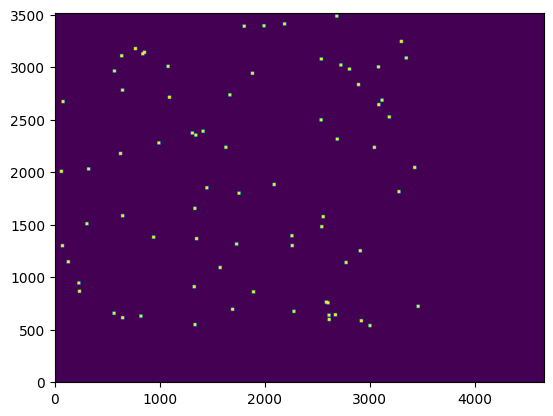

In [172]:
wcs_input_dict = {
    'CTYPE1': 'RA---TAN', 
    'CUNIT1': 'deg', 
    'CDELT1': (px_ra.to(u.deg)).value, 
    'CRPIX1': ccd_width_px/2 - 1, 
    'CRVAL1': ra2016, 
    'NAXIS1': ccd_width_px,
    'CTYPE2': 'DEC--TAN', 
    'CUNIT2': 'deg', 
    'CDELT2': (px_dec.to(u.deg)).value, 
    'CRPIX2': ccd_height_px/2 - 1, 
    'CRVAL2': dec2016, 
    'NAXIS2': ccd_height_px
}
coor_width_range_deg = ccd_width_range_deg / np.cos(np.deg2rad(dec2016))
wcs_dict = wcs.WCS(wcs_input_dict)
image = np.zeros((ccd_height_px,ccd_width_px))
x = wcs_dict.wcs_world2pix([[ra2016 +(coor_width_range_deg.value/2),dec2016+(ccd_height_range_deg.value/2)]],0)
pixs = wcs_dict.wcs_world2pix(entries['ra'].value, entries['dec'].value, 0)
for i in range(len(pixs[0])):
    image[int(pixs[0][i])-15:int(pixs[0][i])+15,int(pixs[1][i])-15:int(pixs[1][i])+15] = 1
plt.imshow(image, origin='lower')